# Explore here



Step 0: Import libraries and data

In [40]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import statsmodels.api as sm
import pickle
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#Load data
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"

df_raw = pd.read_csv(url)

Step 1: Basic exploration

In [4]:
df_raw.info()
#7 variables, 1338 obs, no nulls
#Data type 'object': probably categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df_raw.sample(10)
#Sex, smoker and region are categorical
#Dataset heterogéneo (distintos datatypes)

,age,sex,bmi,children,smoker,region,charges
597,34,female,33.250,1,no,northeast,5594.84550
770,61,male,36.100,3,no,southwest,27941.28758
93,35,male,34.770,2,no,northwest,5729.00530
11,62,female,26.290,0,yes,southeast,27808.72510
145,29,female,38.830,3,no,southeast,5138.25670
1022,47,male,36.080,1,yes,southeast,42211.13820
620,30,male,31.400,1,no,southwest,3659.34600
934,32,male,37.180,2,no,southeast,4673.39220
1118,33,male,35.750,1,yes,southeast,38282.74950
1314,30,female,23.655,3,yes,northwest,18765.87545


Step 2: Variable transformation

In [6]:
df_raw.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [7]:
df_raw.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [8]:
df_raw.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [9]:
#Encoding (codificamos valor de variables categóricas)
#Rule: columnas de la clase x = categorías - 1 (Ej.: región tiene 4 categorías, necesito 3 columnas para evitar colinealidad)
#Could also be done with get dummies

df_raw['sex_aux'] = df_raw['sex'].apply(lambda x:1 if x == 'female' else 0)
df_raw['smoker_aux'] = df_raw['smoker'].apply(lambda x:1 if x == 'yes' else 0)
df_raw['region_sw'] = df_raw['region'].apply(lambda x:1 if x == 'southwest' else 0)
#southeast es la de referencia, por eso no creamos columna para southeast
df_raw['region_nw'] = df_raw['region'].apply(lambda x:1 if x == 'northwest' else 0)
df_raw['region_ne'] = df_raw['region'].apply(lambda x:1 if x == 'northeast' else 0)

df_raw = df_raw.drop(['sex', 'smoker', 'region'], axis = 1)
df_interim = df_raw.copy()

In [10]:
df_interim.sample(10)

,age,bmi,children,charges,sex_aux,smoker_aux,region_sw,region_nw,region_ne
1136,44,25.000,1,7623.51800,1,0,1,0,0
194,18,34.430,0,1137.46970,0,0,0,0,0
342,60,27.550,0,13217.09450,1,0,0,0,1
492,18,25.080,0,2196.47320,1,0,0,0,1
651,53,39.600,1,10579.71100,1,0,0,0,0
507,21,23.750,2,3077.09550,0,0,0,1,0
224,42,24.640,0,19515.54160,0,1,0,0,0
573,62,36.860,1,31620.00106,1,0,0,0,1
41,31,36.630,2,4949.75870,1,0,0,0,0
745,50,30.115,1,9910.35985,1,0,0,1,0


Step 3: EDA

* Step 3.1: Select train and test data

In [11]:
X = df_interim[['age', 'bmi', 'children', 'sex_aux', 'smoker_aux', 'region_sw', 'region_nw', 'region_ne']] #IV
y = df_interim['charges'] #DV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)

* Step 3.2: Data descriptive stats

In [12]:
X_train.describe()

,age,bmi,children,sex_aux,smoker_aux,region_sw,region_nw,region_ne
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.430708,30.729467,1.091725,0.494516,0.199402,0.256231,0.235294,0.246261
std,14.111544,6.135503,1.219257,0.500219,0.399750,0.436769,0.424394,0.431047
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,30.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,34.800000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,64.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Step 3.3: Univariate analysis

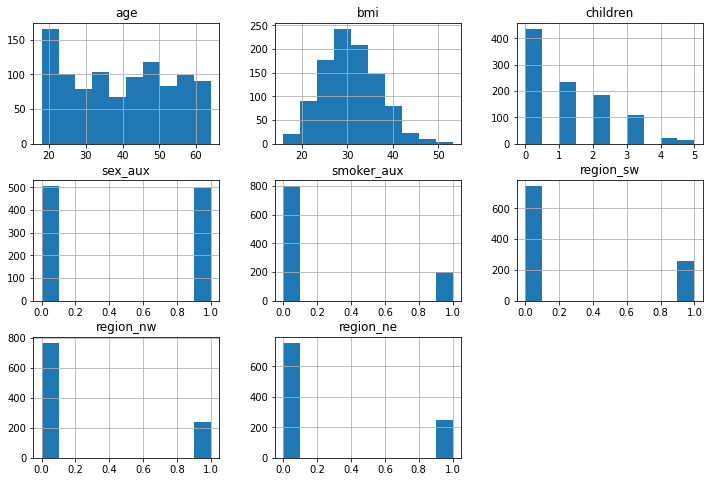

In [13]:
#Histogram
X_train.hist(figsize=(12,8))
plt.show()

#BMI parece normal
#Age parece estar balanceada aunque tiene un pico en 20
#Children la mayoría no tiene

* Step 3.4: Bivariate analysis (One var against the other)

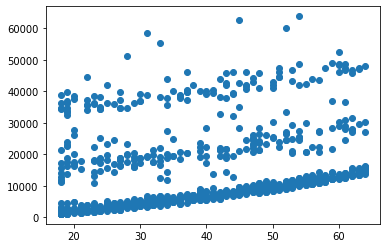

In [14]:
#Scatter plot
plt.scatter(x = X_train['age'], y = y_train)
plt.show()

#No se ve una relación lineal pero podríamos pensar que hay 3 clases 
#porque el costo del seguro puede variar según edad

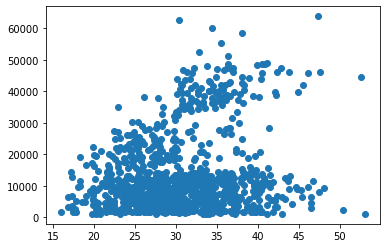

In [15]:
#Scatter plot
plt.scatter(x = X_train['bmi'], y = y_train)
plt.show()
#Podemos ver tres estratas

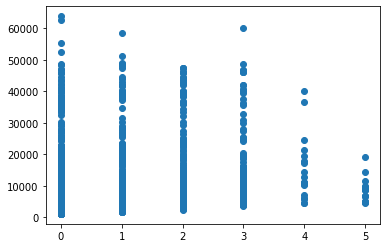

In [16]:
#Scatter plot
plt.scatter(x = X_train['children'], y = y_train)
plt.show()

* Step 3.5: Ver correlaciones

In [17]:
X_train.corr()
#No hay correlación (es casi 0, ninguna es mayor que 0.8) entre niños y edad, niños con bmi

,age,bmi,children,sex_aux,smoker_aux,region_sw,region_nw,region_ne
age,1.000000,0.107326,0.037435,0.036953,-0.045139,0.016242,0.005725,0.010930
bmi,0.107326,1.000000,0.010865,-0.055698,0.009927,-0.000027,-0.118244,-0.148080
children,0.037435,0.010865,1.000000,-0.008993,0.027960,0.021414,0.021897,-0.018336
sex_aux,0.036953,-0.055698,-0.008993,1.000000,-0.114309,0.013289,0.010785,0.017841
smoker_aux,-0.045139,0.009927,0.027960,-0.114309,1.000000,-0.047136,-0.047407,-0.007253
region_sw,0.016242,-0.000027,0.021414,0.013289,-0.047136,1.000000,-0.325578,-0.335494
region_nw,0.005725,-0.118244,0.021897,0.010785,-0.047407,-0.325578,1.000000,-0.317063
region_ne,0.010930,-0.148080,-0.018336,0.017841,-0.007253,-0.335494,-0.317063,1.000000


In [18]:
X_train.corr().style.background_gradient(cmap = 'Blues')
#Same but looks prettier

,age,bmi,children,sex_aux,smoker_aux,region_sw,region_nw,region_ne
age,1.000000,0.107326,0.037435,0.036953,-0.045139,0.016242,0.005725,0.010930
bmi,0.107326,1.000000,0.010865,-0.055698,0.009927,-0.000027,-0.118244,-0.148080
children,0.037435,0.010865,1.000000,-0.008993,0.027960,0.021414,0.021897,-0.018336
sex_aux,0.036953,-0.055698,-0.008993,1.000000,-0.114309,0.013289,0.010785,0.017841
smoker_aux,-0.045139,0.009927,0.027960,-0.114309,1.000000,-0.047136,-0.047407,-0.007253
region_sw,0.016242,-0.000027,0.021414,0.013289,-0.047136,1.000000,-0.325578,-0.335494
region_nw,0.005725,-0.118244,0.021897,0.010785,-0.047407,-0.325578,1.000000,-0.317063
region_ne,0.010930,-0.148080,-0.018336,0.017841,-0.007253,-0.335494,-0.317063,1.000000


* Step 4: Fit model

Reminder: 
<br> La variable dependiente es *charges*
<br> Las variables independientes son *age, bmi, children, sex, smoker* y *region*


4.1 Regresión lineal con constante

In [19]:
model = LinearRegression() #Initialize
model.fit(X_train, y_train) #Fit

print( "Intercept: ", model.intercept_ )
print("Variables: ", X_train.columns)
print( "Coeficientes: ", model.coef_ )

Intercept:  -13188.887965032352
Variables:  Index(['age', 'bmi', 'children', 'sex_aux', 'smoker_aux', 'region_sw',
       'region_nw', 'region_ne'],
      dtype='object')
Coeficientes:  [  259.28377294   334.33013348   560.38480047   216.92164981
 24043.57115706   169.84707402   948.64699482  1159.01410243]


In [20]:
#Another way of doing it:
X_interceptor = sm.add_constant(X_train)
model2 = sm.OLS(y_train, X_interceptor)
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     351.2
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          1.85e-283
Time:                        21:19:27   Log-Likelihood:                -10183.
No. Observations:                1003   AIC:                         2.038e+04
Df Residuals:                     994   BIC:                         2.043e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.319e+04   1288.395    -10.237      0.000   -1.57e+04   -1.07e+04
age          259.2838     14.094     18.396      0.000     231.626     286.942
bmi          334.3301     33.696      9.922      0.000     268.206     400.454
children     560.3848    161.831      3.463      0.001     242.816     877.954
sex_aux      216.9216    397.204      0.546      0.585    -562.532     996.376
smoker_aux  2.404e+04    499.031     48.181      0.000    2.31e+04     2.5e+04
region_sw    169.8471    557.092      0.305      0.761    -923.364    1263.058
region_nw    948.6470    577.717      1.642      0.101    -185.037    2082.331
region_ne   1159.0141    572.395      2.025      0.043      35.773    2282.255
==============================================================================
Omnibus:                      231.741   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.491
Skew:                           1.239   Prob(JB):                    3.53e-119
Kurtosis:                       5.629   Cond. No.                         357.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
y_pred = model.predict(X_test)

print('R2:', metrics.r2_score(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred,squared=False))

#Note to self: Estas son métricas del dataset de prueba 
#Note to self: El R2 significa que 78% de la variable dependiente está explicada por la varianza de la independiente
#Note to self: Cuanto más cercano a 1 es el R square mejor ajusta el modelo, o sea la y estaría siendo 'perfectamente' explicada por las x

R2: 0.7866857073627449
MAE: 4023.6471495940405
MSE: 30723136.82688005
RMSE: 5542.845553222645


4.2 Regresión lineal sin constante

In [30]:
model3 = LinearRegression(fit_intercept= False) #Initialize
model3.fit(X_train, y_train) #Fit
y_pred2 = model3.predict(X_test) #Predict

In [31]:
print('R2:', metrics.r2_score(y_test, y_pred2))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred2))
print('MSE:', metrics.mean_squared_error(y_test, y_pred2))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred2,squared=False))

R2: 0.7606663419369057
MAE: 4340.556812511617
MSE: 34470642.510833606
RMSE: 5871.170454929204


4.3 Regresión con término de segundo grado

In [37]:
poly_features = PolynomialFeatures(degree = 2) #Parábola

X_poly_train = poly_features.fit_transform(X_train) 
X_poly_test = poly_features.fit_transform(X_test)

model4 = model.fit(X_poly_train, y_train)

y_pred3 = model4.predict(X_poly_test) #Predict

In [38]:
print('R2:', metrics.r2_score(y_test, y_pred3))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred3))
print('MSE:', metrics.mean_squared_error(y_test, y_pred3))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred3,squared=False))

R2: 0.7490362357845053
MAE: 4391.277562892537
MSE: 36145698.30861344
RMSE: 6012.129265793729


El modelo con mejor performance es la regresión lineal con intercepto
<br> *(Pregunta para quien me corrija la task: No es raro que el lineal fittee mejor? No me doy cuenta si hice algo mal)*

In [41]:
filename = '../models/final_model.sav'
pickle.dump(model, open(filename, 'wb'))